In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!conda create --name maltaomics
!conda activate maltaomics
!conda install -c conda-forge rdkit

In [27]:
import rdkit # compchem library
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole # use this to draw molecules in the notebook
from rdkit import rdBase
print(rdkit.__version__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

2023.03.3


Data for this exercise taken from the [DUD-E validation dataset](http://dude.docking.org/targets/try1).

In [3]:
def get_mols(smi_file):
    mols = []
    with open(smi_file) as f:
        for l in f:
            mols.append(l.split()[0])
    return mols

In [6]:
from google.colab import files
uploaded = files.upload()
uploaded = files.upload()

In [10]:
n = 200 # balance sets equally
actives = [ Chem.MolFromSmiles(m) for m in get_mols('try1_actives_final.ism')[:n] ]
decoys = [ Chem.MolFromSmiles(m) for m in get_mols('try1_decoys_final.ism')[:n] ]

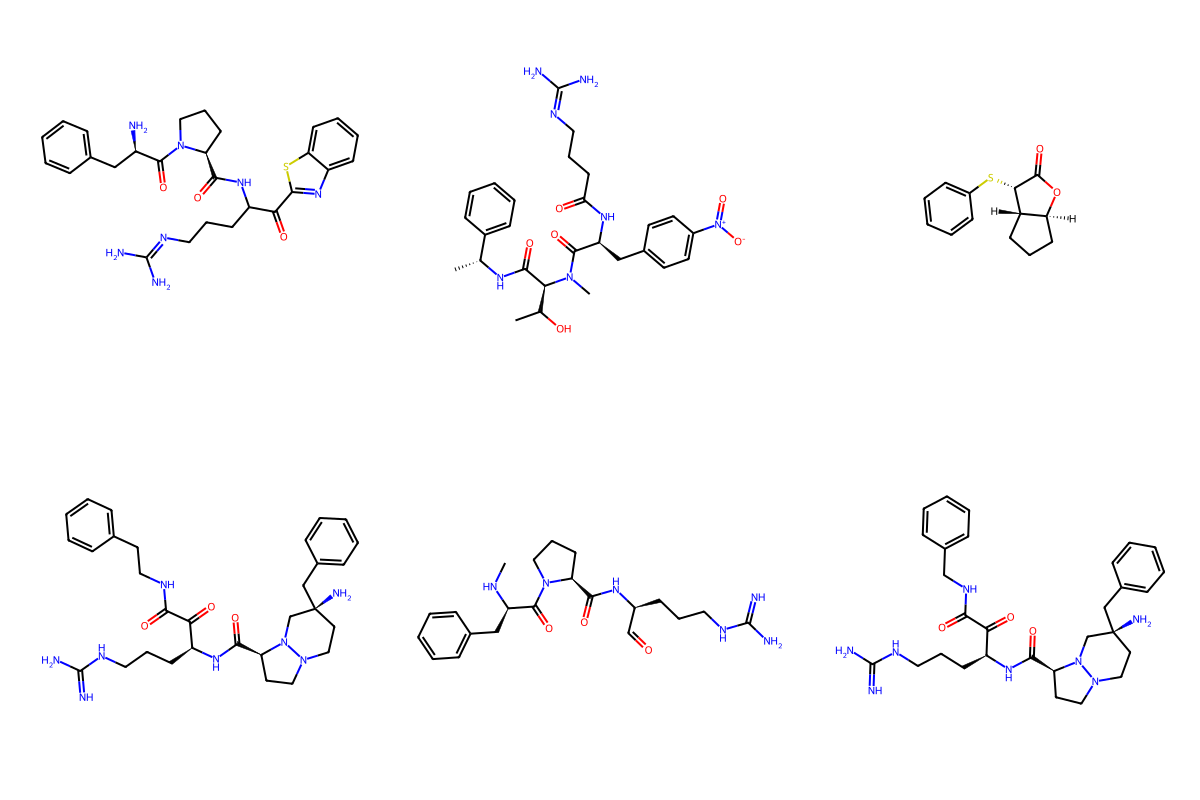

In [11]:
img = Draw.MolsToGridImage( actives[:6], molsPerRow=3, subImgSize=(400, 400))
img

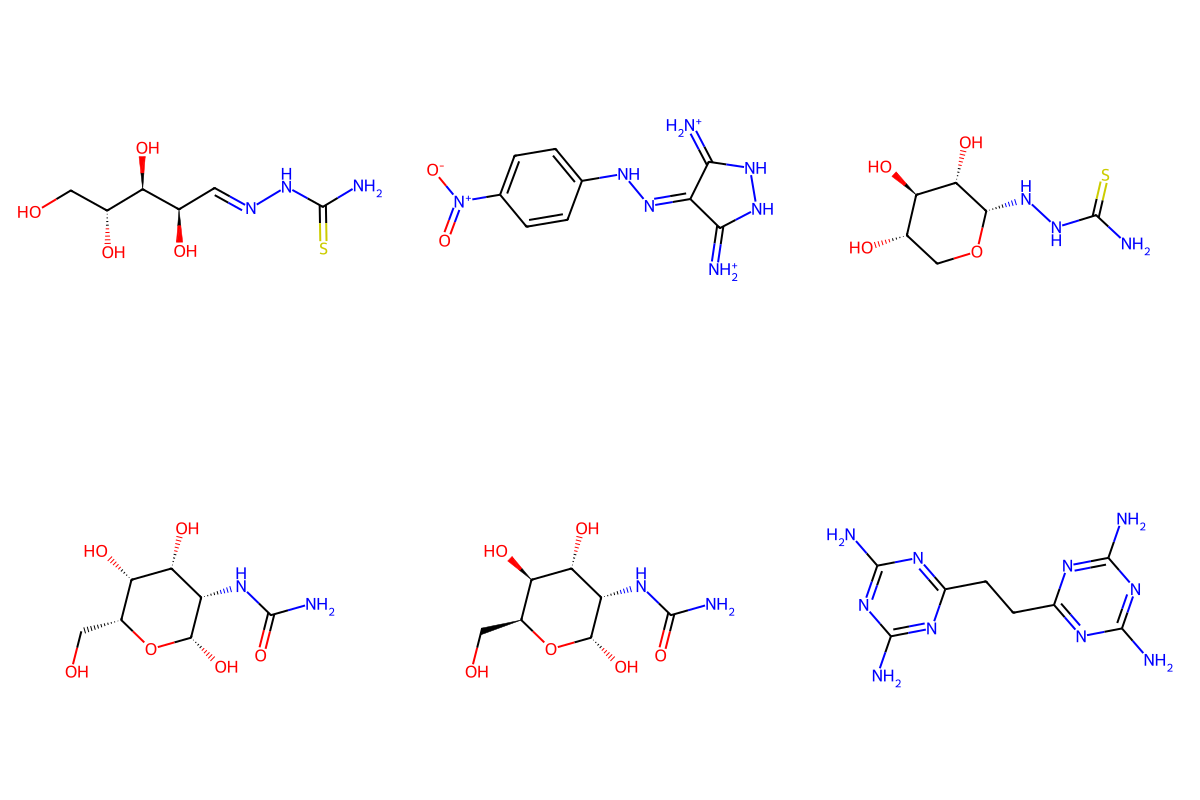

In [12]:
img = Draw.MolsToGridImage( decoys[:6], molsPerRow=3, subImgSize=(400, 400))
img

We need to generate properties for each molecule in the actives and decoy testing sets

In [13]:
mol = pd.Series(decoys + actives)
target_classes = np.array(['DECOY', 'ACTIVE'])
mol_labels = pd.Series(([target_classes[0]] * n) + ([target_classes[1]] * n))
df = pd.DataFrame()
df['molecule'] = mol
df['class'] = mol_labels
df['mol_weight'] = [ Descriptors.MolWt(m) for m in df['molecule'] ]
df['rot_bonds'] =  [ Descriptors.NumRotatableBonds(m) for m in df['molecule'] ]
df['h_donors'] =   [ Descriptors.NumHDonors(m) for m in df['molecule'] ]
df['h_acceptors'] = [ Descriptors.NumHAcceptors(m) for m in df['molecule'] ]
df['log_p'] = [ Descriptors.MolLogP(m) for m in df['molecule'] ]
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
df

,molecule,class,mol_weight,rot_bonds,h_donors,h_acceptors,log_p,is_train
0,<rdkit.Chem.rdchem.Mol object at 0x7d708b783680>,DECOY,223.254,5,6,6,-3.11960,True
1,<rdkit.Chem.rdchem.Mol object at 0x7d708b7836f0>,DECOY,249.234,3,5,4,-3.21430,True
2,<rdkit.Chem.rdchem.Mol object at 0x7d708b783760>,DECOY,223.254,2,6,6,-3.23680,True
3,<rdkit.Chem.rdchem.Mol object at 0x7d708b7837d0>,DECOY,222.197,2,6,6,-3.54540,True
4,<rdkit.Chem.rdchem.Mol object at 0x7d708b783840>,DECOY,222.197,2,6,6,-3.54540,True
...,...,...,...,...,...,...,...,...
395,<rdkit.Chem.rdchem.Mol object at 0x7d708b7830d0>,ACTIVE,519.645,11,3,4,5.40077,False
396,<rdkit.Chem.rdchem.Mol object at 0x7d708b783140>,ACTIVE,494.643,7,3,5,5.43844,True
397,<rdkit.Chem.rdchem.Mol object at 0x7d708b7831b0>,ACTIVE,494.573,7,3,7,2.56277,False
398,<rdkit.Chem.rdchem.Mol object at 0x7d708b783220>,ACTIVE,507.572,8,4,7,2.43337,True


In [14]:
train, test = df[df['is_train'] == True], df[df['is_train'] == False]

In [15]:
train.head()

,molecule,class,mol_weight,rot_bonds,h_donors,h_acceptors,log_p,is_train
0,<rdkit.Chem.rdchem.Mol object at 0x7d708b783680>,DECOY,223.254,5,6,6,-3.1196,True
1,<rdkit.Chem.rdchem.Mol object at 0x7d708b7836f0>,DECOY,249.234,3,5,4,-3.2143,True
2,<rdkit.Chem.rdchem.Mol object at 0x7d708b783760>,DECOY,223.254,2,6,6,-3.2368,True
3,<rdkit.Chem.rdchem.Mol object at 0x7d708b7837d0>,DECOY,222.197,2,6,6,-3.5454,True
4,<rdkit.Chem.rdchem.Mol object at 0x7d708b783840>,DECOY,222.197,2,6,6,-3.5454,True


In [16]:
test.head()

,molecule,class,mol_weight,rot_bonds,h_donors,h_acceptors,log_p,is_train
6,<rdkit.Chem.rdchem.Mol object at 0x7d708b783920>,DECOY,222.197,2,6,6,-3.5454,False
11,<rdkit.Chem.rdchem.Mol object at 0x7d708b783b50>,DECOY,326.298,3,7,10,-4.3696,False
13,<rdkit.Chem.rdchem.Mol object at 0x7d708b783bc0>,DECOY,242.235,2,5,8,-2.2050,False
14,<rdkit.Chem.rdchem.Mol object at 0x7d708b783ca0>,DECOY,254.254,2,6,2,-7.1630,False
28,<rdkit.Chem.rdchem.Mol object at 0x7d708b77c350>,DECOY,232.328,8,4,2,-3.4868,False


In [17]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 295
Number of observations in the test data: 105


In [18]:
features = df.columns[2:7]

# View features names
features

Index(['mol_weight', 'rot_bonds', 'h_donors', 'h_acceptors', 'log_p'], dtype='object')

In [19]:
y = pd.factorize(train['class'])
y # training classes

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1]),
 

In [20]:
clf = RandomForestClassifier(n_estimators=100)

If you want a (Gaussian) Naive Bayes instead ...

```python
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
```

In [21]:
model = clf.fit(train[features], y[0])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [22]:
predictions = clf.predict(test[features])
predictions

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [23]:
clf.predict_proba(test[features])[:10]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


array([[1.  , 0.  ],
       [1.  , 0.  ],
       [0.98, 0.02],
       [0.84, 0.16],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.7 , 0.3 ],
       [1.  , 0.  ]])

In [24]:
preds = target_classes[predictions]
preds

array(['DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'ACTIVE', 'DECOY', 'DECOY', 'DECOY', 'ACTIVE', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'DECOY', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'DECOY', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'DECOY', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'DECOY', 'ACTIVE', 'DECOY', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE

In [25]:
# confusion matrix
pd.crosstab(test['class'], preds, rownames=['Actual Class'], colnames=['Predicted Class'])

Predicted Class,ACTIVE,DECOY
Actual Class,,
ACTIVE,51,5
DECOY,2,47


In [28]:
from sklearn import metrics
# accuracy
accuracy_score = metrics.accuracy_score(test['class'], preds)
print(accuracy_score)
# f1 score
f1_score = metrics.f1_score(test['class'], preds, pos_label="ACTIVE")
print(f1_score)

0.9333333333333333
0.9357798165137615


Average precision-recall score: 0.92


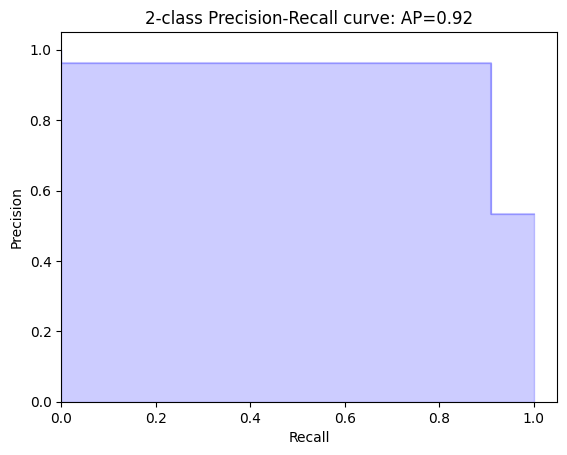

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

numeric_preds = [1 if cls == "ACTIVE" else 0 for cls in test['class']]

precision, recall, _ = precision_recall_curve(numeric_preds, predictions)

average_precision = average_precision_score(numeric_preds, predictions)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt;


In [30]:
list(zip(train[features], clf.feature_importances_))

[('mol_weight', 0.44866880054870156),
 ('rot_bonds', 0.0946383287175474),
 ('h_donors', 0.05706824617084996),
 ('h_acceptors', 0.19590680493271564),
 ('log_p', 0.2037178196301855)]

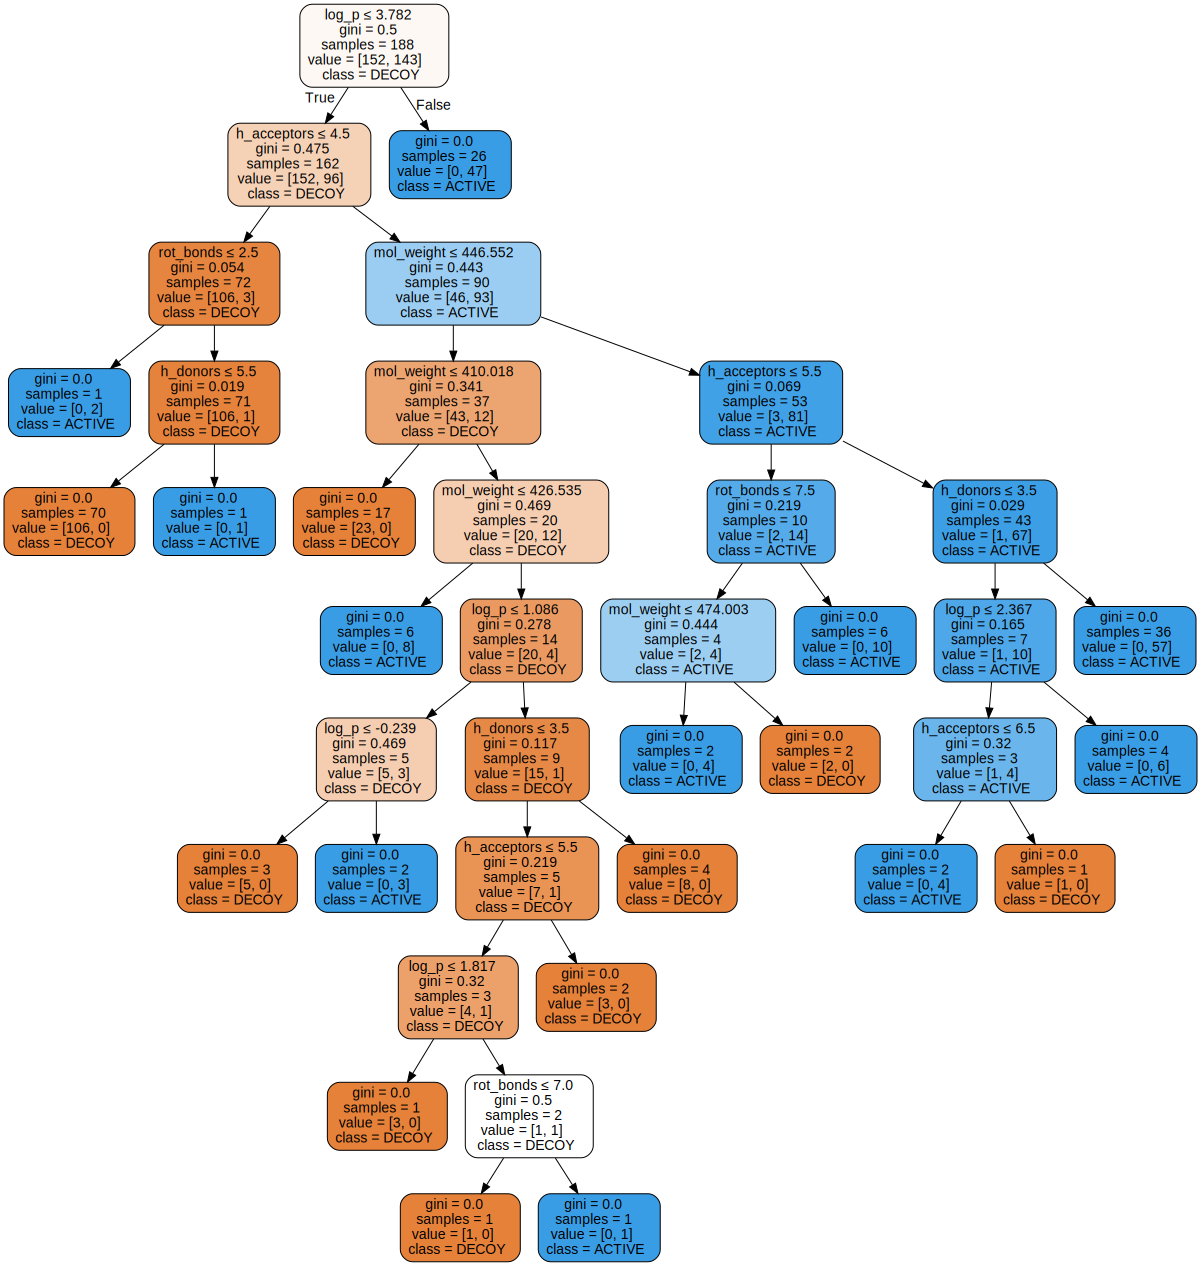

In [31]:
from sklearn import tree
import graphviz

# just one three for an example
trees =  [estimator for estimator in clf.estimators_]
single_tree = trees[0]

dot_data = tree.export_graphviz(single_tree, out_file=None,
                         feature_names=features,
                         class_names=target_classes,
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph


# Practical Tasks

You are required to:

* Compute Accuracy of Model (plot a ROC curve)
* Build a Naive Bayes Classifier Model
* Test the models on more data (what is the accuracy?)
* Investigate the use of more training data
* Investigate the use of unbalanced sets for
    1. Training
    2. Testing
